In [16]:
from scipy import stats
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch_lr_finder
from torch_lr_finder import LRFinder, TrainDataLoaderIter
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GAT, GATConv
import matplotlib.pyplot as plt

In [2]:
# Reproducibility
torch_geometric.seed_everything(0)

In [3]:
# Helper functions

""" Takes an integer from 0 to 99 and returns a 2-digit string representation"""
def int_to_str_2digit(x):
  assert(type(x)==int)
  assert(0 <= x and x <= 99)
  if 0 <= x and x <= 10:
    return "0"+str(x)
  else: return str(x)

""" Create filename for model i weights """
def sgd_filename(i):
  return filename+int_to_str_2digit(i)+".pt"

""" Calculate relative change """
def rel_change(new, old):
    return abs((new - old)) / old

In [4]:
# Global constants
batch_size=64
m=64 # for m-sharpness
dropout=0.6
learning_rate=2.36E-01
hidden_channels=8
heads=8
nb_models=50
filename="SGD_GAT_"
nb_sgd_epochs_min = 10
nb_sgd_epochs_max = 20
nb_pga_epochs = 5
nb_pga_trials = 5
rho = 0.02 # Radius of the L_inf ball
criterion = torch.nn.CrossEntropyLoss()
stop_crit = 0.05

In [5]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid/', name='Cora', transform=NormalizeFeatures())

# Couple the node vectors and edge indices for compatibility with LRFinder
x = dataset.data.x.to(device)
e = dataset.data.edge_index.to(device)
y = dataset.data.y.to(device)
tr_mask = dataset[0].train_mask
te_mask = dataset[0].test_mask
va_mask = dataset[0].val_mask

C:\Users\oilio\Miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [6]:
# Dataset characteristics
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2 # Pytorch Geometric saves each link as undirected edge
tr_len = dataset[0].train_mask.sum()
te_len = dataset[0].test_mask.sum()
val_len = dataset[0].val_mask.sum()
other_len = num_nodes - tr_len - te_len - val_len

# Name of the dataset?
print(f"Dataset: {dataset.name}")

# How many nodes for training, validation, and testing?
print(f"Number of nodes: {num_nodes} (train={tr_len}, val={val_len}, test={te_len}, other={other_len})")

# How many edges are there?
print(f"Number of edges: {num_edges}")

# How many features on each node?
print(f"Number of node features: {dataset.num_node_features}")

# How many classes of data are there?
print(f"Number of classes: {dataset.num_classes}")

# Realising that this DataSet isn't compatible with PyTorch Dataloader.
print(f"Dataset len: {dataset.len()}")

Dataset: Cora
Number of nodes: 2708 (train=140, val=500, test=1000, other=1068)
Number of edges: 5278
Number of node features: 1433
Number of classes: 7
Dataset len: 1


In [7]:
# Check that the training data is balanced
unique_nums, counts = np.unique(dataset.data.y[tr_mask], return_counts=True)
frequency_dict = dict(zip(unique_nums, counts))
print("Train class frequnecy:", frequency_dict)

# The test data is balanced?
# Check that the training data is balanced
unique_nums, counts = np.unique(dataset.data.y[te_mask], return_counts=True)
frequency_dict = dict(zip(unique_nums, counts))
print("Test class frequency:", frequency_dict)

Train class frequnecy: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20}
Test class frequency: {0: 130, 1: 91, 2: 144, 3: 319, 4: 149, 5: 103, 6: 64}


In [8]:
"""Get batch masks for from training mask without replacement"""
def batch_masks():

  # Get which nodes are used for training
  tr_nodes = np.array(range(num_nodes))[tr_mask]

  # Shuffle the node indices
  np.random.shuffle(tr_nodes)

  # Compute closest multiple of batch_size
  target_length = int(np.ceil(len(tr_nodes) / batch_size) * batch_size)

  # Calculate the amount of padding needed
  padding = target_length - len(tr_nodes)

  # Pad the array indices as to use convenient numpy reshape
  tr_nodes = np.pad(tr_nodes, (0, padding), constant_values=tr_nodes[-1], mode='constant')

  # Reshape into batches
  batches = tr_nodes.reshape(-1, batch_size)

  # Encode these indices as node masks
  masks = np.array([np.repeat(False, num_nodes) for i in range(len(batches))])
  for i, mask in enumerate(masks):
    mask[batches[i]]= True

  return masks

"""Get a single sub-mask from training mask with replacement"""
def get_mask(size):

  # Assert that there are more nodes than size
  assert(size < tr_len)

  # Get which nodes are used for training
  tr_nodes = np.array(range(num_nodes))[tr_mask]

  # Sample with replacement
  sample = np.random.choice(tr_nodes, size=size, replace=True)

  # Encode these indices as a mask
  mask = np.repeat(False, num_nodes)
  mask[sample] = True
  return mask

In [9]:
def create_model():
  return GAT(dataset.num_features, hidden_channels, 2, dataset.num_classes, dropout=dropout, act='elu').to(device)

In [10]:
# Train the model
def train(model, criterion, optimizer, do_update=True):
  model.train()

  train_loss=0
  for mask in batch_masks():
    optimizer.zero_grad()
    out = model(x, e)
    loss = criterion(out[mask], y[mask])
    loss.backward()
    train_loss += loss.item()

    if do_update:
      optimizer.step()

  return train_loss

# Evaluate the model
def test(model, criterion):
  model.eval()

  out = model(x, e)
  pred = out.argmax(dim=1)
  test_loss = criterion(out[te_mask], y[te_mask])
  correct = int(pred[te_mask].eq(y[te_mask]).sum())
  acc = correct / te_len

  return acc.item(), test_loss.item()

In [11]:
# Create GAT models: SGD with suggested LR & Cross-Entropy Loss
for i in range(nb_models):
  # Create the GAT model and optimizer
  model = create_model()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Training loop
  prev_loss = float('inf')
  for epoch in range(nb_sgd_epochs_max):
      curr_loss = train(model, criterion, optimizer)
      if epoch >= nb_sgd_epochs_min and rel_change(curr_loss, prev_loss) < stop_crit:
        break
      else:
        prev_loss = curr_loss

  torch.save(model.state_dict(), sgd_filename(i))

In [12]:
# Project model onto L_inf ball of radius epsilon around the frozen weights
def project_weights(model, rho, fixed_w):
    with torch.no_grad():
        for i, param in enumerate(model.parameters()):
            param.data = torch.clamp(param.data, fixed_w[i]-(rho * abs(fixed_w[i])), fixed_w[i]+(rho * abs(fixed_w[i])))

In [13]:
# Compute Adaptive Worst-case Sharpness with Projected Gradient Ascent
sharpnesses = []
for i in range(nb_models):
  model = create_model()
  model.load_state_dict(torch.load(sgd_filename(i)))
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  fixed_w = [param.clone().data for param in list(model.parameters())]

  # Compute training loss on original model without updating
  tr_loss_fixed = train(model, criterion, optimizer, False)

  # PGA runs
  avg_train_loss = 0
  for j in range(nb_pga_trials):

    # Reload model and optimizer
    model.load_state_dict(torch.load(sgd_filename(i)))
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Get a mask of m training samples
    mask = get_mask(m)

    # PGA epochs
    max_tr_loss_new = 0
    for k in range(nb_pga_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(x,e)
        # Invert criterion to search for worst-case sharpness
        loss = -criterion(out[mask], y[mask])
        loss.backward()
        optimizer.step()

        # Project weights onto the L_inf ball after each batch
        project_weights(model, rho, fixed_w)

        # Save training loss where the model ends up
        tr_loss_new = train(model, criterion, optimizer, False)

        # Record if highest over epochs
        max_tr_loss_new = max(tr_loss_new, max_tr_loss_new)

    # Sum up to average later
    avg_train_loss += max_tr_loss_new

  # Get approximation of expected training loss
  avg_train_loss /= nb_pga_trials

  # Record adaptive worst-case sharpness
  sharpnesses += [avg_train_loss - tr_loss_fixed]

In [14]:
# Compute test losses
test_losses = []
accuracies = []
for i in range(nb_models):
  model = create_model()
  model.load_state_dict(torch.load(sgd_filename(i)))
  test_acc, test_loss = test(model, criterion)
  test_losses += [test_loss]
  accuracies += [test_acc]

In [17]:
# Compute and save correlation coefficients
tau, pval = stats.kendalltau(sharpnesses, test_losses)
print(tau, pval)
str(tau)[:6]
print(min(accuracies), max(accuracies))

-0.1853061224489796 0.057587789761809095
0.29500001668930054 0.7640000581741333


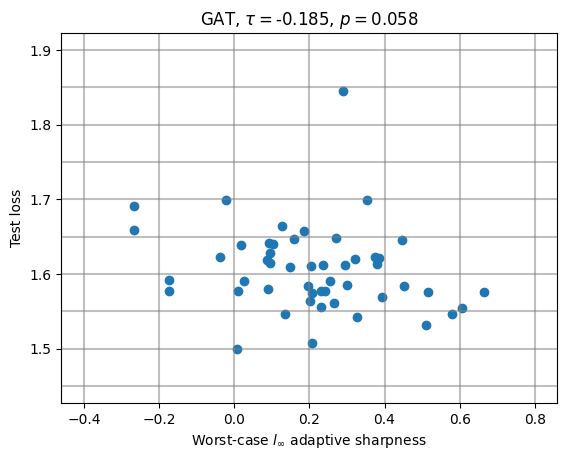

In [18]:
# Create scatter plot
plt.scatter(sharpnesses, test_losses)

# Add grey vertical lines
for x in plt.xticks()[0]:
    plt.axvline(x=x, color='grey', alpha=0.5)

# Add grey horizontal lines
for y in plt.yticks()[0]:
    plt.axhline(y=y, color='grey', alpha=0.5)

# Set labels and title
plt.xlabel('Worst-case '+r'$l_{\infty}$'+' adaptive sharpness')
plt.ylabel('Test loss')
plt.title('GAT, '+r'$\tau=$'+ f'{tau:.3f}' + r', $p=$' + f'{pval:.3f}')

# Display the plot
plt.show()